**Generating ImageLists needed to obtain visual features by Decetron2**

Following the tutorial https://colab.research.google.com/drive/1bLGxKdldwqnMVA5x4neY7-l_8fKGWQYI?usp=sharing#scrollTo=643yOpAZwRWq.

In [1]:
import torch
torch.__version__

'2.3.0+cu121'

In [2]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%%capture
#!pip install pyyaml==5.1
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' # because FastRCNNOutputs is not there anymore, they changed the codebase
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'

In [4]:
import torch, torchvision
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from copy import deepcopy

In [5]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs # check this!
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

In [8]:
# load images
import io
from skimage.io import imshow
from skimage.io import imread
from google.colab import files
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# CHANGE ALL FILES AFTER BALANCING CLASSES AND UPLOAD NEW ONES
image_path = '/content/drive/MyDrive/data/images' # all images from balanced data set()

# load data sets with image file names, descriptions, and painters
data_path = '/content/drive/MyDrive/data/'
train_df = pd.read_csv(os.path.join(data_path, 'train_bal.csv'))
val_df = pd.read_csv(os.path.join(data_path, 'val_bal.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test_bal.csv'))

dfs = [train_df, val_df, test_df]

# get image paths for train, val, test sets by keeping order of data frames
image_paths_train = []
image_paths_val = []
image_paths_test = []

for index,row in train_df.iterrows():
  file_name = row["IMAGE_FILE"]
  image_paths_train.append(os.path.join(image_path,file_name))

for index,row in val_df.iterrows():
  file_name = row["IMAGE_FILE"]
  image_paths_val.append(os.path.join(image_path,file_name))

for index,row in test_df.iterrows():
  file_name = row["IMAGE_FILE"]
  image_paths_test.append(os.path.join(image_path,file_name))

n_train = len(image_paths_train)
n_val = len(image_paths_val)
n_test = len(image_paths_test)

print(len(image_paths_train))
print(len(image_paths_test))
print(len(image_paths_val))

image_paths_train1 = image_paths_train[:1000]
image_paths_train2 = image_paths_train[1000:]


Mounted at /content/drive
1602
89
89


In [9]:
# SANITY CHECKS
print(image_paths_train[0:5])
print()
print(image_paths_val[0:5])
print()
print(image_paths_test[0:5])

['/content/drive/MyDrive/data/images/16346-virtu_4.jpg', '/content/drive/MyDrive/data/images/16980-2hague03.jpg', '/content/drive/MyDrive/data/images/33896-11noremb.jpg', '/content/drive/MyDrive/data/images/35604-06landsc.jpg', '/content/drive/MyDrive/data/images/39730-6perseus.jpg']

['/content/drive/MyDrive/data/images/17212-copies04.jpg', '/content/drive/MyDrive/data/images/35430-55religi.jpg', '/content/drive/MyDrive/data/images/41360-06sancta.jpg', '/content/drive/MyDrive/data/images/10271-03juris2.jpg', '/content/drive/MyDrive/data/images/38929-09clemen.jpg']

['/content/drive/MyDrive/data/images/35618-02hippop.jpg', '/content/drive/MyDrive/data/images/35406-08assum.jpg', '/content/drive/MyDrive/data/images/35379-13religi.jpg', '/content/drive/MyDrive/data/images/39715-1ferra3.jpg', '/content/drive/MyDrive/data/images/10171-1salome5.jpg']


In [10]:
train_df.head()

,IMAGE_FILE,DESCRIPTION,AUTHOR,comment_length
0,16346-virtu_4.jpg,The figures of Justice and Injustice are large...,GIOTTO di Bondone,348
1,16980-2hague03.jpg,"Catalogue numbers: F 4, JH 187.In the years 18...","GOGH, Vincent van",314
2,33896-11noremb.jpg,Catalogue number: Bredius 109.[PAINTER]'s life...,REMBRANDT Harmenszoon van Rijn,624
3,35604-06landsc.jpg,Saint George and the Dragon symbolises the clo...,"RUBENS, Peter Paul",2685
4,39730-6perseus.jpg,This painting is one of the six 'poesie' paint...,TIZIANO Vecellio,81


In [11]:
val_df.head()

,IMAGE_FILE,DESCRIPTION,AUTHOR,comment_length
0,17212-copies04.jpg,"Catalogue numbers: F 696, JH 1786","GOGH, Vincent van",33
1,35430-55religi.jpg,Rubens' close involvement with the resurgence ...,"RUBENS, Peter Paul",518
2,41360-06sancta.jpg,"On the south wall, in the Crucifixion of St Pe...","UNKNOWN MASTER, Italian",641
3,10271-03juris2.jpg,The sitter of this portrait is the wife of a V...,"CRANACH, Lucas the Elder",459
4,38929-09clemen.jpg,"The painting shows Pope Clement I at prayer, i...","TIEPOLO, Giovanni Battista",573


In [12]:
test_df.head()

,IMAGE_FILE,DESCRIPTION,AUTHOR,comment_length
0,35618-02hippop.jpg,Rubens produced a number of large format hunti...,"RUBENS, Peter Paul",99
1,35406-08assum.jpg,The Antwerp Cathedral was given a new marble h...,"RUBENS, Peter Paul",1077
2,35379-13religi.jpg,After Sebastian had survived execution by bowm...,"RUBENS, Peter Paul",1644
3,39715-1ferra3.jpg,In 1516 [PAINTER] made contact with Alfonso I ...,TIZIANO Vecellio,2032
4,10171-1salome5.jpg,The biblical source for the painting is Matthe...,"CRANACH, Lucas the Elder",782


In [13]:
from tqdm import tqdm
import pickle

# load and convert images

#image_paths = [os.path.join('images', filename) for filename in os.listdir('images')]

image_list_train = [cv2.cvtColor(plt.imread(image_path), cv2.COLOR_RGB2BGR) for image_path in tqdm(image_paths_train)]
#image_list_val = [cv2.cvtColor(plt.imread(image_path), cv2.COLOR_RGB2BGR) for image_path in image_paths_val]
#image_list_test = [cv2.cvtColor(plt.imread(image_path), cv2.COLOR_RGB2BGR) for image_path in image_paths_test]

# split image_list_train into two because it's too much data
#image_list_train1 = [cv2.cvtColor(plt.imread(image_path), cv2.COLOR_RGB2BGR) for image_path in tqdm(image_paths_train1, desc='Loading images')]
#image_list_train2 = [cv2.cvtColor(plt.imread(image_path), cv2.COLOR_RGB2BGR) for image_path in tqdm(image_paths_train2, desc='Loading images')]

# Define the path to save the list as pickle

save_path_train = "/content/drive/My Drive/image_list_train.pkl"
save_path_train1 = "/content/drive/My Drive/image_list_train1.pkl"
save_path_train2 = "/content/drive/My Drive/image_list_train2.pkl"
save_path_val = "/content/drive/My Drive/image_list_val.pkl"
save_path_test = "/content/drive/My Drive/image_list_test.pkl"


100%|██████████| 1602/1602 [10:40<00:00,  2.50it/s]


In [14]:
# save ImageLists as pkl files

import pickle
#with open(save_path_train1, 'wb') as f:
#  pickle.dump(image_list_train1, f)

#with open(save_path_train2, 'wb') as f:
#  pickle.dump(image_list_train2, f)

with open(save_path_train, 'wb') as f:
    pickle.dump(image_list_train, f)
#with open(save_path_val, 'wb') as f:
  #pickle.dump(image_list_val, f)
#with open(save_path_test, 'wb') as f:
#    pickle.dump(image_list_test, f)

**Test whether image order was maintained**



89
(1005, 710, 3)


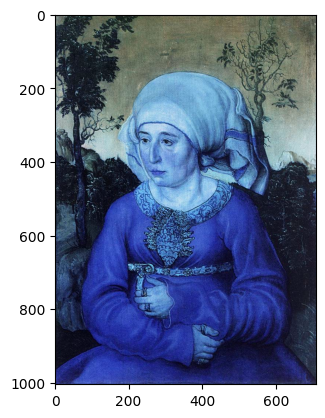

10271-03juris2.jpg
The sitter of this portrait is the wife of a Vienna University law professor. The pendant of this painting, representing the professor, is in the Germanisches Nationalmuseum in Nuremberg. Husband and wife are each flanked a sprouting and a dying tree. Significantly, the two healthy trees face each other, seen on the inner sides of the pendants when hung together. Their emblematic message suggests that only in each other's presence may this couple flourish
CRANACH, Lucas the Elder


In [39]:
with open(save_path_val, 'rb') as f:
  image_list_val = pickle.load(f)

print(len(image_list_val))
image = image_list_val[3]
print(image.shape)
plt.imshow(image)
plt.show()

print(val_df.iloc[3]["IMAGE_FILE"])
print(val_df.iloc[3]["DESCRIPTION"])
print(val_df.iloc[3]["AUTHOR"])

(1005, 710, 3)


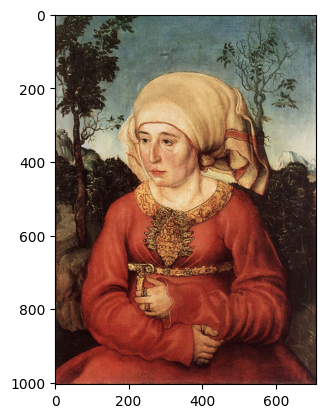

In [40]:
# original image (not in RGB)
image_path_img1 = os.path.join(image_path, val_df.iloc[3]["IMAGE_FILE"])
img1= plt.imread(image_path_img1)
print(img1.shape)
plt.imshow(img1)
plt.show()